## limpieza y procesamiento de tablas

0. Juntar tablas de proyectos y evaluadores (uno a muchos)
1. Aplicar limpieza y steamming
2. Agrupar textos por evaluador
3. Análisis de longitud de textos por investigador

---




In [1]:
import pandas as pd
import pickle

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from math import sqrt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize
import heapq

from joblib import load, dump
nltk.download('wordnet')
nltk.download('punkt')

stemmer = SnowballStemmer('spanish')

pd.options.mode.chained_assignment = None #...
import seaborn as sns


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielbustillos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielbustillos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Descripción del proyecto:

In [26]:
data_topics = pd.read_csv("../data/solicitudes_con_modalidad/solicitudes.csv")

In [35]:
# data_topics = load("../data/solicitudes_2019/solicitudes-ciencia-frontera.csv")
data_topics.rename({"resumen_es":"DESCRIPCION_PROYECTO"}, inplace=True, axis=1)
data_topics.head(2)


,convocatoria,clave,proyecto_id,id_area,area,id_campo,campo,id_disciplina,disciplina,id_subdisciplina,...,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17
0,Ciencia de Frontera 2019,CF-MG-20191107191915010-4647203,4647203,1,Ciencias físico matemáticas y ciencias de la t...,4,Física,24,Fisica estadística,604,...,stress test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ciencia de Frontera 2019,CF-MG-20191105031440822-2574574,2574574,3,Medicina y ciencias de la salud,121,Investigación médica,837,"Enfermedades infecciosas, bacteriología clínic...",4856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
data_topics.columns

Index(['convocatoria', 'clave', 'proyecto_id', 'id_area', 'area', 'id_campo',
       'campo', 'id_disciplina', 'disciplina', 'id_subdisciplina',
       'subdisciplina', 'modalidad', 'estatus_envio', 'estatus_propuesta',
       'titulo_es', 'DESCRIPCION_PROYECTO', 'resumen_en', 'razon_social',
       'reniecyt', 'entidad_federativa', 'tipo_institucion', 'rt_cvu',
       'rt_nombre', 'rt_apellido_paterno', 'rt_apellido_materno', 'rt_correo',
       'rt_nivelsni', 'ra_cvu', 'ra_nombre', 'ra_apellido_paterno',
       'ra_apellido_materno', 'ra_correo', 'ra_nivelsni', 'rl_cvu',
       'rl_nombre', 'rl_apellido_paterno', 'rl_apellido_materno', 'rl_correo',
       'rl_nivelsni', 'fecha_envio', 'palabrasclave', 'pc1', 'pc2', 'pc3',
       'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12',
       'pc13', 'pc14', 'pc15', 'pc16', 'pc17'],
      dtype='object')

Funciones para estandarizar y limpiar los datos:

In [37]:
def clean_str_series(s):
    """
    info:
    """
    
    s = s.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8') \
         .str.capitalize().str.strip().str.replace('[^\w\s]','')
    return s

In [38]:
def text_cleaner(df,columns_to_clean,columns_not_na):
    """
    info:
    """
    
    
    # Quitar registros no validos
    df = df.dropna(subset=columns_not_na,axis=0)

    # Formato texto
    for d in columns_to_clean:
        if df[d].dtype == object: 
            df[d] = clean_str_series(df[d])
    
    return df

In [39]:
columns_not_na = ["DESCRIPCION_PROYECTO"]
columns_interes = ["DESCRIPCION_PROYECTO"]

data_topics_clean = text_cleaner(data_topics, columns_to_clean=columns_interes, columns_not_na=columns_not_na)

In [40]:
data_topics_clean.head()

,convocatoria,clave,proyecto_id,id_area,area,id_campo,campo,id_disciplina,disciplina,id_subdisciplina,...,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17
0,Ciencia de Frontera 2019,CF-MG-20191107191915010-4647203,4647203,1,Ciencias físico matemáticas y ciencias de la t...,4,Física,24,Fisica estadística,604,...,stress test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ciencia de Frontera 2019,CF-MG-20191105031440822-2574574,2574574,3,Medicina y ciencias de la salud,121,Investigación médica,837,"Enfermedades infecciosas, bacteriología clínic...",4856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ciencia de Frontera 2019,CF-MG-20191025151637887-1098668,1098668,7,Ingeniería y tecnología,32,Ingeniería,279,Ingeniería electrónica,3009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ciencia de Frontera 2019,CF-MG-20191018115318179-373922,373922,4,Humanidades y ciencias de la conducta,17,Pedagogía,149,Otras especialidades pedagógicas,2216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ciencia de Frontera 2019,CF-MG-20191105072112144-2574577,2574577,7,Ingeniería y tecnología,30,Ciencias tecnológicas,250,Otras especialidades tecnológicas,3281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


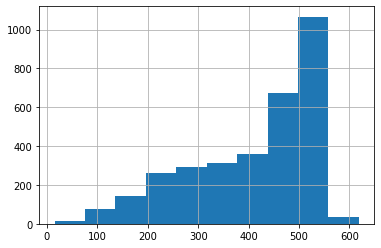

In [45]:
data_topics_clean["DESCRIPCION_PROYECTO"].str.count(" ").hist()

Número total de evaluadores:

### Steamming

In [46]:
min_len = 4

def stemSentence(sentence, min_len=min_len):
    """
    info
    """
    
    token_words = word_tokenize(sentence)
    stem_sentence = []
    
    for word in token_words:
        if len(word) > min_len:
            stem_sentence.append(stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')))
            stem_sentence.append(" ")
    return "".join(stem_sentence)

obtener raices y quitar palabras cortas

In [47]:
%%time 
text_data = data_topics_clean["DESCRIPCION_PROYECTO"]
text_data = text_data.apply(stemSentence)

data_topics_clean["DESCRIPCION_PROYECTO"] = text_data

CPU times: user 27.2 s, sys: 314 ms, total: 27.5 s
Wall time: 29.1 s


In [52]:
data_topics_clean.head()

,convocatoria,clave,proyecto_id,id_area,area,id_campo,campo,id_disciplina,disciplina,id_subdisciplina,...,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17
0,Ciencia de Frontera 2019,CF-MG-20191107191915010-4647203,4647203,1,Ciencias físico matemáticas y ciencias de la t...,4,Física,24,Fisica estadística,604,...,stress test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ciencia de Frontera 2019,CF-MG-20191105031440822-2574574,2574574,3,Medicina y ciencias de la salud,121,Investigación médica,837,"Enfermedades infecciosas, bacteriología clínic...",4856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ciencia de Frontera 2019,CF-MG-20191025151637887-1098668,1098668,7,Ingeniería y tecnología,32,Ingeniería,279,Ingeniería electrónica,3009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ciencia de Frontera 2019,CF-MG-20191018115318179-373922,373922,4,Humanidades y ciencias de la conducta,17,Pedagogía,149,Otras especialidades pedagógicas,2216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ciencia de Frontera 2019,CF-MG-20191105072112144-2574577,2574577,7,Ingeniería y tecnología,30,Ciencias tecnológicas,250,Otras especialidades tecnológicas,3281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
data_topics_clean.columns = [nombre.upper() for nombre in data_topics_clean.columns]

In [58]:
dump(data_topics_clean, "../data/solicitudes_con_modalidad/datos_solicitudes_2019.pkl")

['../data/solicitudes_con_modalidad/datos_solicitudes_2019.pkl']

## Dataset evaluadores:

In [49]:
data_eval = load("../data/solicitudes_con_modalidad/datos_solicitudes_2019.pkl")
data_eval.shape

FileNotFoundError: [Errno 2] No such file or directory: '../data/solicitudes_con_modalidad/datos_solicitudes_2019.pkl'

In [28]:
data_eval.head()

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,CVU
0,1093,CATEDRAS-2015-01,2015,31151.0
1,1235,CATEDRAS-2015-01,2015,18804.0
2,1235,CATEDRAS-2015-01,2015,4867.0
3,554,CATEDRAS-2015-01,2015,3188.0
4,390,CATEDRAS-2015-01,2015,2195.0


## Merge de proyectos y evaluadores

Se duplicarán registros...

In [29]:
data = data_topics_clean.merge(data_eval, on=["ID_PROYECTO","NUMERO_CONVOCATORIA","ANIO"])
data

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,PALABRAS_CLAVE,SUBDISCIPLINA,DISCIPLINA,AREA,TITULO,DESCRIPCION_PROYECTO,CVU
0,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,1006.0
1,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,772.0
2,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,1006.0
3,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,772.0
4,390,CATEDRAS-2016-01,2016,NaN,NaN,NaN,NaN,Fortalecimiento de la Maestría en Ciencias Odo...,program dependent institucion especial reumato...,13142.0
...,...,...,...,...,...,...,...,...,...,...
52979,7166,PROBLEMAS-2017-01,2017,"Medición e instrumentación,Metrología,Evaluaci...",INSTRUMENTACION Y CONTROL,INGENIERÍA MECÁNICA,INGENIERÍA Y TECNOLOGÍA,Evaluación de Tecnología Policial,antecedent coordinacion innovacion tecnolog ad...,123020.0
52980,7166,PROBLEMAS-2017-01,2017,"Medición e instrumentación,Metrología,Evaluaci...",INSTRUMENTACION Y CONTROL,INGENIERÍA MECÁNICA,INGENIERÍA Y TECNOLOGÍA,Evaluación de Tecnología Policial,antecedent coordinacion innovacion tecnolog ad...,201178.0
52981,7166,PROBLEMAS-2017-01,2017,"Medición e instrumentación,Metrología,Evaluaci...",INSTRUMENTACION Y CONTROL,INGENIERÍA MECÁNICA,INGENIERÍA Y TECNOLOGÍA,Evaluación de Tecnología Policial,antecedent coordinacion innovacion tecnolog ad...,14922.0
52982,7166,PROBLEMAS-2017-01,2017,"Medición e instrumentación,Metrología,Evaluaci...",INSTRUMENTACION Y CONTROL,INGENIERÍA MECÁNICA,INGENIERÍA Y TECNOLOGÍA,Evaluación de Tecnología Policial,antecedent coordinacion innovacion tecnolog ad...,67671.0


In [30]:
data.shape

(52984, 10)

In [31]:
data.head()

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,PALABRAS_CLAVE,SUBDISCIPLINA,DISCIPLINA,AREA,TITULO,DESCRIPCION_PROYECTO,CVU
0,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,1006.0
1,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,772.0
2,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,1006.0
3,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,772.0
4,390,CATEDRAS-2016-01,2016,NaN,NaN,NaN,NaN,Fortalecimiento de la Maestría en Ciencias Odo...,program dependent institucion especial reumato...,13142.0


# nos quedamos con el primer elemento de las siguientes columnas para generar dummies

In [32]:
data.head(2)

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,PALABRAS_CLAVE,SUBDISCIPLINA,DISCIPLINA,AREA,TITULO,DESCRIPCION_PROYECTO,CVU
0,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,1006.0
1,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,772.0


In [33]:
dump(data, "../data/data_convocatorias.pkl")

['../data/data_convocatorias.pkl']

In [34]:
data.to_csv("../data/data_convocatorias.csv")

In [35]:
data

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,PALABRAS_CLAVE,SUBDISCIPLINA,DISCIPLINA,AREA,TITULO,DESCRIPCION_PROYECTO,CVU
0,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,1006.0
1,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,772.0
2,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,1006.0
3,1120,CATEDRAS-2015-01,2015,NaN,NaN,NaN,NaN,FORTALECIMIENTO DEL LABORATORIO DE ODONTOLOGÍA...,result formacion recurs human trav asesori tes...,772.0
4,390,CATEDRAS-2016-01,2016,NaN,NaN,NaN,NaN,Fortalecimiento de la Maestría en Ciencias Odo...,program dependent institucion especial reumato...,13142.0
...,...,...,...,...,...,...,...,...,...,...
52979,7166,PROBLEMAS-2017-01,2017,"Medición e instrumentación,Metrología,Evaluaci...",INSTRUMENTACION Y CONTROL,INGENIERÍA MECÁNICA,INGENIERÍA Y TECNOLOGÍA,Evaluación de Tecnología Policial,antecedent coordinacion innovacion tecnolog ad...,123020.0
52980,7166,PROBLEMAS-2017-01,2017,"Medición e instrumentación,Metrología,Evaluaci...",INSTRUMENTACION Y CONTROL,INGENIERÍA MECÁNICA,INGENIERÍA Y TECNOLOGÍA,Evaluación de Tecnología Policial,antecedent coordinacion innovacion tecnolog ad...,201178.0
52981,7166,PROBLEMAS-2017-01,2017,"Medición e instrumentación,Metrología,Evaluaci...",INSTRUMENTACION Y CONTROL,INGENIERÍA MECÁNICA,INGENIERÍA Y TECNOLOGÍA,Evaluación de Tecnología Policial,antecedent coordinacion innovacion tecnolog ad...,14922.0
52982,7166,PROBLEMAS-2017-01,2017,"Medición e instrumentación,Metrología,Evaluaci...",INSTRUMENTACION Y CONTROL,INGENIERÍA MECÁNICA,INGENIERÍA Y TECNOLOGÍA,Evaluación de Tecnología Policial,antecedent coordinacion innovacion tecnolog ad...,67671.0
